# <center><strong>Natural Language Processing dan Text Mining</strong></center>
    
## <center><strong><font color="blue">II.1. Klasifikasi Teks dan Sentiment Analysis</font></strong></center>
<img alt="" src="images/SocMed.png" style="height: 171px; width: 600px;" /> 
    
## <center>(C) Taufik Sutanto - 2020 </center>

## <font color="blue">Outline :</font>

* Brief Review Representasi Dokumen
* Corpus-Based Sentiment Analysis
* Metode Supervised untuk Sentiment Analysis 

## Refresh Model Klasifikasi disini: https://tau-data.id/slcm-01/

In [ ]:
# Jalankan Cell ini "HANYA" jika anda menggunakan Google Colab
# Jika di jalankan di komputer local, silahkan lihat NLPTM-02 untuk instalasinya.
import nltk

!wget https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/taudataNlpTm.py
!mkdir data
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/slang.txt
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_id.txt
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_en.txt
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-ind-def.tab
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-msa-all.tab
!wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/all_indo_man_tag_corpus_model.crf.tagger

!pip install spacy python-crfsuite unidecode textblob sastrawi
!python -m spacy download en
!python -m spacy download xx
!python -m spacy download en_core_web_sm

nltk.download('popular')

In [1]:
# Mulai dengan loading data
import pickle
from sklearn.datasets import fetch_20newsgroups

try:
    f = open('data/20newsgroups.pckl', 'rb')
    data = pickle.load(f)
    f.close()
except:
    categories = ['sci.med', 'talk.politics.misc',  'rec.autos']
    data = fetch_20newsgroups(categories=categories,remove=('headers', 'footers', 'quotes'))
    f = open('data/20newsgroups.pckl', 'wb')
    pickle.dump(data, f)
    f.close()
'Done'

'Done'

In [2]:
# Merubah data ke bentuk yang biasa kita gunakan
D = [doc for doc in data.data]
Y = data.target
'Done'

'Done'

In [4]:
Y

array([0, 2, 0, ..., 2, 1, 1], dtype=int64)

In [5]:
D[0]

'I want to get a car alarm and I am thinking about getting an Ungo Box.\n    Does anyone out there have any knowledge or experience with any of\n    these alarms?  How about price ranges for the different models?\n    Are these good car alarms?  Please email me any responces.\n\n                cak3@ns3.lehigh.edu'

In [4]:
# pre processing
import taudataNlpTm as tau 
from tqdm import tqdm

# cleanText(T, fix={}, lemma=None, stops = set(), symbols_remove = True, min_charLen = 2, fixTag= True)
stops, lemmatizer = tau.LoadStopWords(lang='en')
for i,d in tqdm(enumerate(D)):
    D[i] = tau.cleanText(d, lemma=lemmatizer, stops = stops, symbols_remove = True, min_charLen = 2)
print(D[0])

1653it [00:02, 627.25it/s]

car alarm thinking ungo box knowledge experience alarms price ranges models good car alarms email responces cak3 ns3.lehigh.edu


In [5]:
# Bentuk VSM-nya
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',smooth_idf= True, sublinear_tf=True, 
                                   ngram_range=(1, 2), max_df=0.90, min_df=2)

In [6]:
from sklearn.model_selection import train_test_split
seed = 99

x_train, x_test, y_train, y_test = train_test_split(D, Y, test_size=0.3, random_state=seed)
x_train = tfidf_vectorizer.fit_transform(x_train) # "Fit_Transform"
x_test = tfidf_vectorizer.transform(x_test) # Perhatikan disini hanya "Transform"

print(x_train.shape, x_test.shape) # Jumlah kolom Sama ==> ini penting

(1157, 13127) (496, 13127)


In [8]:
# Jangan lupa langkah penting ini! ... 
# Kenapa ada yang kosong?... coba fikirkan ... 
def hapusKosong(X,Y):
    Y = Y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, Y

x_train, y_train = hapusKosong(x_train, y_train)
x_test, y_test = hapusKosong(x_test, y_test)
print(x_train.shape, x_test.shape)

(1105, 13127) (481, 13127)


In [9]:
# Kita gunakan metric yang umum
from sklearn.metrics import accuracy_score

In [10]:
# Naive Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
nbc = gnb.fit(x_train.toarray(), y_train) # Kelemahan Implementasinya disini

y_nbc = nbc.predict(x_test.toarray())
accuracy_score(y_test, y_nbc)
# Hati-hati Sparse ==> Dense bisa memenuhi memory untuk data relatif cukup besar
# Akurasi cukup baik

0.8669438669438669

In [11]:
# Decision Tree: http://scikit-learn.org/stable/modules/tree.html
from sklearn import tree

DT = tree.DecisionTreeClassifier()
DT = DT.fit(x_train, y_train)

y_DT = DT.predict(x_test)
accuracy_score(y_test, y_DT)
# Akurasi relatif rendah ==> Mengapa?

0.7110187110187111

In [12]:
# Mari coba perbaiki dengan Random Forest
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier()
RandomForest.fit(x_train, y_train)

y_RF = RandomForest.predict(x_test)
accuracy_score(y_test, y_RF)
# Sedikit membaik (expected)

0.8648648648648649

In [13]:
# SVM: http://scikit-learn.org/stable/modules/svm.html
from sklearn import svm

dSVM = svm.SVC(decision_function_shape='ovo') # oneversus one SVM
dSVM.fit(x_train, y_train)

y_SVM = dSVM.predict(x_test)
accuracy_score(y_test, y_SVM)
# Mengapa akurasinya rendah? Mengejutkan?

0.918918918918919

In [16]:
# Neural Network: http://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(hidden_layer_sizes=(30, 40))
NN.fit(x_train, y_train)

y_NN = NN.predict(x_test)
accuracy_score(y_test, y_NN)
# Cukup Baik, coba rubah jumlah layer dan Neuron

0.9147609147609148

## Tunggu dulu ... yang kita lakukan belum cukup valid/objektif ... Mengapa?


<h1>Cross Validation</h1>

<h1><img alt="" src="images/6_Cross_validation.png" style="height:274px; width:485px" /></h1>


In [18]:
# Cross validation
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
from sklearn.model_selection import cross_val_score
import time

# perhatikan sekarang kita menggunakan seluruh data
# Bisa juga CV di training data ==> train, Test, Val splittting system
X = tfidf_vectorizer.fit_transform(D) # "Fit_Transform"

svm_ = svm.SVC(kernel='linear', decision_function_shape='ovo')
mulai = time.time()
scores_svm = cross_val_score(svm_, X, Y, cv=10, n_jobs=-2) 
waktu = time.time() - mulai
# Interval Akurasi 95 CI 
print("Accuracy SVM: %0.2f (+/- %0.2f), Waktu = %0.3f detik" % (scores_svm.mean(), scores_svm.std() * 2, waktu))

Accuracy SVM: 0.91 (+/- 0.04), Waktu = 11.556 detik


In [22]:
# Bandingkan dengan Neural Network
nn_ = MLPClassifier(hidden_layer_sizes=(30, 40))
mulai = time.time()
scores_nn = cross_val_score(nn_, X, Y, cv=10, n_jobs=-2) 
waktu = time.time() - mulai
# Interval Akurasi 95 CI 
print("Accuracy ANN: %0.2f (+/- %0.2f), Waktu = %0.3f detik" % (scores_nn.mean(), scores_nn.std() * 2, waktu))

Accuracy ANN: 0.92 (+/- 0.05), Waktu = 125.937 detik


In [23]:
# Kita bisa juga mengeluarkan metric evaluasi lainnya
scores = cross_val_score(svm_, X, Y, cv=10, scoring='f1_macro')
print("F1-Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# scoring pilih dari sini: http://scikit-learn.org/stable/modules/model_evaluation.html

F1-Score: 0.91 (+/- 0.04)


In [24]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt; plt.style.use('classic')
import numpy as np, pandas as pd

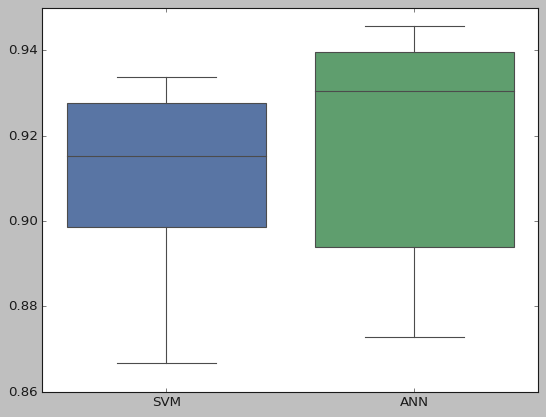

In [25]:
df = pd.DataFrame({'SVM':scores_svm,'ANN':scores_nn})
sns.boxplot(data=df)
plt.show()

<img alt="" src="images/9_Sentiment_Analysis_Meme.jpg"  />

<p><strong>Apakah sentiment analysis?</strong></p>

<p>Sentiment Analysis adalah suatu proses komputasi untuk menentukan apakah suatu penrnyataan bermakna positive, negative, atau netral.</p>

<p>Terkadang disebut juga sebagai&nbsp;<strong>opinion mining.</strong></p>

<p><strong>Contoh aplikasi Sentiment Analysis</strong></p>

<ul>
	<li><strong>Business: tanggapan konsumen atas suatu produk</strong>.</li>
	<li><strong>Politics:&nbsp;</strong>Sentimen masyarakat sebagai strategi pemenangan pemilu/pilkada.</li>
</ul>


<img alt="" src="images/9_SA_techniques.jpg" />

In [26]:
from textblob import TextBlob
# Lexicon Based berdasarkan 
# pattern = https://www.clips.uantwerpen.be/pages/pattern-en#sentiment
Sentence = "I hate Bakpia"
testimonial = TextBlob(Sentence)
print(testimonial.sentiment)
print('Polarity=Sentimen =', testimonial.sentiment.polarity)

Sentiment(polarity=-0.8, subjectivity=0.9)
Polarity=Sentimen = -0.8


<p>Sentiment menghasilkan Tuple berpasangan (<strong>Polaritas</strong>, <strong>Subjectivitas</strong>).&nbsp;</p>

<p>Polaritas memiliki nilai [-1, 1] ==&gt; negative~positive Sentimen</p>

<p>Subjectivity memiliki nilai antara 0 sampai 1, dimana 0 paling objective dan 1 paling subjective.</p>

## Bagaimana Dengan Bahasa Indonesia?
<p>[A simple trick]</p>

In [31]:
kalimat = 'Saya benci Bakpia'
K = TextBlob(kalimat).translate(to='en')
print(type(K), K)

<class 'textblob.blob.TextBlob'> I hate Bakpia


In [33]:
print(K.sentiment)
print('Polarity=Sentimen =', K.sentiment.polarity)

Sentiment(polarity=-0.8, subjectivity=0.9)
Polarity=Sentimen = -0.8


In [34]:
def SenSubModMood_ID(kalimat):
    K = TextBlob(kalimat).translate(to='en')
    pol,sub = K.sentiment
    if pol>0:
        pol='positive'
    elif pol<0:
        pol='negative'
    else:
        pol = 'netral'
    if sub>0.5:
        sub = 'Subjektif'
    else:
        sub = "Objektif"
    return pol, sub

In [35]:
kalimat = 'makan bakpia pakai kecap enak'
SenSubModMood_ID(kalimat)

('positive', 'Subjektif')

In [36]:
from textblob.sentiments import NaiveBayesAnalyzer
# Warning, mungkin lambat karena membentuk model classifier* terlebih dahulu.
# *Berdasarkan NLTK corpus ==> Language dependent
Sentence = "Textblob is amazingly simple to use"
blob = TextBlob(Sentence, analyzer=NaiveBayesAnalyzer())
blob.sentiment
# Good Explanation: https://medium.com/nlpython/sentiment-analysis-analysis-ee5da4448e37
# Output probabilitas prediksinya

Sentiment(classification='pos', p_pos=0.7952586206896557, p_neg=0.2047413793103446)

## Bagaimana dengan Sentiment Analysis menggunakan NBC untuk Bahasa indonesia?

In [41]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
 
def word_feats(words):
    return dict([(word, True) for word in words])

def bentukClassifier(wPos, wNeg): # ,Nt
    positive_features = [(word_feats(pos), 'pos') for pos in wPos]
    negative_features = [(word_feats(neg), 'neg') for neg in wNeg]
    #neutral_features = [(word_feats(neu), 'neu') for neu in Nt]
    train_set = negative_features + positive_features# + neutral_features
    return NaiveBayesClassifier.train(train_set)

def prediksiSentiment(kalimat, wPos, wNeg, negasi):
    pos, neg = 0.0, 0.0
    posWords, negWords = [], []
    K = tau.cleanText(kalimat)
    for w in wPos:
        if w in K:
            for ww in negasi:
                kebalikan = False
                inverted = ww+' '+w
                if inverted in K:
                    negWords.append(inverted)
                    kebalikan = True
                    break
            if not kebalikan:
                posWords.append(w)
    for w in wNeg:
        if w in K:
            for ww in negasi:
                kebalikan = False
                inverted = ww+' '+w
                if inverted in K:
                    posWords.append(inverted)
                    kebalikan = True
                    break
            if not kebalikan:
                negWords.append(w)
    
    nPos, nNeg = len(posWords), len(negWords)
    sum_ = nPos + nNeg
    if sum_ == 0 or nPos==nNeg:
        return 'netral', 0.0
    else:
        nPos, nNeg = nPos/sum_, nNeg/sum_
        if nPos>nNeg and nPos>0.01:
            return 'positif', nPos
        elif nNeg>nPos and nNeg<-0.01:
            return 'negatif', nNeg
        else:
            return 'netral', (nPos + nNeg)/2

In [43]:
wPos = ('keren', 'suka', 'cinta', 'bagus', 'mantap', 'sadis', 'top', 'enak', 'sedap')
wNeg = ('jelek', 'benci','buruk', 'najis')
wordS = (wPos, wNeg)
negasi = ['ga', 'tidak']

In [42]:
sentence = "makan pempek minumnya teh panas, biasa aja :)"
prediksiSentiment(sentence, wPos, wNeg, negasi)

('netral', 0.0)

In [46]:
sentence = "makan gorengan sambil minum kopi, enak tenan"
prediksiSentiment(sentence, wPos, wNeg, negasi)

('positif', 1.0)

## Bagaimana jika mau melakukannya dengan model klasifikasi (supervised learning) lain seperti modul sebelumnya?
(e.g. SVM, NN, DT, k-NN, etc)

In [47]:
# text Classification : independent variable
d1 = 'Minum kopi pagi-pagi sambil makan pisang goreng is the best'
d2 = 'Belajar NLP dan Text Mining ternyata seru banget'
d3 = 'Palembang agak mendung hari ini'
d4 =  'Sudah lumayan lama tukang Bakso belum lewat'
d5 = 'Aduh ga banget makan Mie Ayam pakai kecap, please deh'
d6 = 'Benci banget kalau melihat orang buang sampah sembarangan di jalan'
d7 = 'Kalau liat orang ga taat aturan rasanya ingin ngegampar aja'
d8 = 'Nikmatnya meniti jalan jalan penuh romansa di tengah kota bernuansa pendidikan'
d9 = 'kemajuan bangsa ini ada pada kegigihan masyarakat dalam belajar dan bekerja'
D = [d1,d2,d3,d4,d5,d6,d7,d8,d9]
'Done!'

'Done!'

In [48]:
# dependent variable, misal 0=positif, 1=netral, 2=negatif
Class = [0,0,1,1,2,2,2,1,0]
dic = {0:'positif', 1:'netral', 2:'negatif'}
print([dic[c] for c in Class])

['positif', 'positif', 'netral', 'netral', 'negatif', 'negatif', 'negatif', 'netral', 'positif']


In [49]:
# Bentuk VSM-nya seperti kemarin (skip preprocessing)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vsm = vectorizer.fit_transform(D)
vsm = vsm[vsm.getnnz(1)>0][:,vsm.getnnz(0)>0] # Remove zero rows and columns
print(vsm.shape)
str(vectorizer.vocabulary_)[:200]

(9, 144)


"{'minum': 91, 'kopi': 65, 'pagi': 104, 'sambil': 122, 'makan': 76, 'pisang': 114, 'goreng': 43, 'is': 51, 'the': 140, 'best': 28, 'minum kopi': 92, 'kopi pagi': 66, 'pagi pagi': 105, 'pagi sambil': 10"

In [50]:
# Lakukan klasifikasi (misal dengan SVM)
dSVM = svm.SVC(kernel='linear')
sen = dSVM.fit(vsm, Class).predict(vsm)
print(accuracy_score(Class, sen))
# Memakai seluruh training data karena sampel yang sangat kecil

1.0


# End of Module

<hr />
<p><img alt="" src="images/6_ML_Class.jpg" style="height:495px; width:640px" /></p>
